In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Conv1D

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None #supress warning

stock_dataframe = pd.read_csv('prices-split-adjusted.csv')
symbol = stock_dataframe[stock_dataframe['symbol'] == 'HAL']

# stock_dataframe = pd.read_csv('BSE_30.csv')
# symbol = stock_dataframe[stock_dataframe['symbol'] == 'ADANIPORTS']

symbol

,date,symbol,open,close,low,high,volume
448,2010-01-04,HAL,30.719999,31.250000,30.660000,31.340000,11571600.0
916,2010-01-05,HAL,31.280001,31.650000,30.990000,31.830000,18989700.0
1384,2010-01-06,HAL,31.740000,32.400002,31.639999,32.590000,15720800.0
1852,2010-01-07,HAL,32.310001,32.480000,31.920000,32.520000,8993100.0
2320,2010-01-08,HAL,32.950001,34.119999,32.490002,34.139999,23014600.0
...,...,...,...,...,...,...,...
848972,2016-12-23,HAL,55.040001,54.840000,54.630001,55.259998,3161500.0
849472,2016-12-27,HAL,55.020000,54.910000,54.700001,55.540001,3608700.0
849972,2016-12-28,HAL,55.110001,54.299999,54.180000,55.220001,4759700.0
850472,2016-12-29,HAL,54.139999,54.040001,53.840000,54.459999,4216800.0


In [3]:
type(symbol)

pandas.core.frame.DataFrame

In [4]:
symbol.drop('symbol', axis = 1,  inplace=True)
symbol.drop('open', axis = 1,  inplace=True)
symbol.drop('low', axis = 1,  inplace=True)
symbol.drop('high', axis = 1,  inplace=True)
symbol.drop('volume', axis = 1,  inplace=True)

# only for bse data
# symbol.drop('Adj Close', axis = 1,  inplace=True)

In [5]:
def EMA(DataFrame,p):
    stock_dataframe = DataFrame.copy()
    stock_dataframe["EMA"]=stock_dataframe["close"].ewm(span=p,min_periods=p).mean() 
    stock_dataframe.dropna(inplace=True)
    return stock_dataframe

In [6]:
symbol = EMA(symbol, 8) 
# period could be b/w 12 and 26 for MACD calculation  
symbol

,date,close,EMA
3724,2010-01-13,34.049999,33.336927
4192,2010-01-14,34.310001,33.578308
4660,2010-01-15,34.029999,33.687532
5128,2010-01-19,34.599998,33.903938
5596,2010-01-20,33.270000,33.755803
...,...,...,...
848972,2016-12-23,54.840000,54.359605
849472,2016-12-27,54.910000,54.481915
849972,2016-12-28,54.299999,54.441489
850472,2016-12-29,54.040001,54.352270


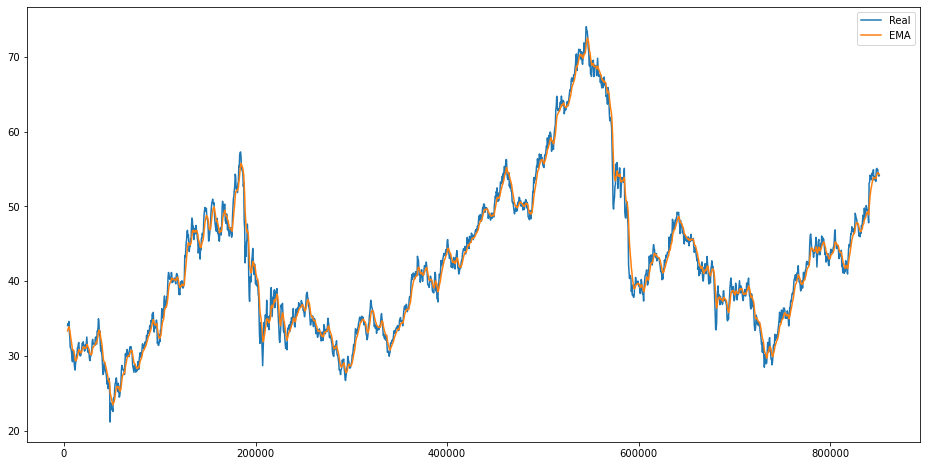

In [7]:
plt.figure(figsize=(16,8))
plt.plot(symbol['close'])
plt.plot(symbol['EMA'])
plt.legend(['Real', 'EMA'])

In [8]:
close = symbol['close']
close = pd.DataFrame(data=close)

In [9]:
symbol.drop('date', axis = 1,  inplace=True)
symbol.drop('close', axis = 1,  inplace=True)

In [10]:
symbol

,EMA
3724,33.336927
4192,33.578308
4660,33.687532
5128,33.903938
5596,33.755803
...,...
848972,54.359605
849472,54.481915
849972,54.441489
850472,54.352270


In [11]:
dataset = symbol.values

dataset

array([[33.33692679],
       [33.57830767],
       [33.68753213],
       ...,
       [54.44148946],
       [54.3522698 ],
       [54.29398762]])

In [12]:
train = dataset[0:1500,:]
valid = dataset[1500:,:]

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1)) # normalizing the data
scaled_data = scaler.fit_transform(dataset)

In [14]:
x_train, y_train = [], []

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [15]:
model = Sequential()
model.add(Dense(20,activation='tanh'))
model.add(Dense(10,activation='tanh'))
model.add(Conv1D(filters=32, kernel_size=3,strides=1, padding="causal", activation="relu", input_shape=[None, 1]))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dense(1))

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
history = model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=1, validation_split = 0.15)

Epoch 1/100


2022-05-01 13:36:55.362219: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 2s 52ms/step - loss: 0.0735 - mae: 0.1987 - val_loss: 0.0319 - val_mae: 0.1738
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0163 - mae: 0.1058 - val_loss: 0.0028 - val_mae: 0.0405
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0090 - mae: 0.0710 - val_loss: 0.0036 - val_mae: 0.0517
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0048 - mae: 0.0539 - val_loss: 0.0013 - val_mae: 0.0293
Epoch 5/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0032 - mae: 0.0434 - val_loss: 0.0012 - val_mae: 0.0282
Epoch 6/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0023 - mae: 0.0346 - val_loss: 7.7049e-04 - val_mae: 0.0211
Epoch 7/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0020 - mae: 0.0340 - val_loss: 7.7840e-04 - val_mae: 0.0220
Epoch 8/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0016

Epoch 60/100
10/10 [==============================] - 0s 21ms/step - loss: 2.9289e-04 - mae: 0.0128 - val_loss: 2.2026e-04 - val_mae: 0.0111
Epoch 61/100
10/10 [==============================] - 0s 21ms/step - loss: 2.8422e-04 - mae: 0.0125 - val_loss: 2.8769e-04 - val_mae: 0.0132
Epoch 62/100
10/10 [==============================] - 0s 21ms/step - loss: 3.2278e-04 - mae: 0.0133 - val_loss: 1.9703e-04 - val_mae: 0.0102
Epoch 63/100
10/10 [==============================] - 0s 21ms/step - loss: 3.2961e-04 - mae: 0.0135 - val_loss: 1.9582e-04 - val_mae: 0.0101
Epoch 64/100
10/10 [==============================] - 0s 21ms/step - loss: 3.0741e-04 - mae: 0.0131 - val_loss: 2.8243e-04 - val_mae: 0.0131
Epoch 65/100
10/10 [==============================] - 0s 21ms/step - loss: 2.8023e-04 - mae: 0.0123 - val_loss: 1.9379e-04 - val_mae: 0.0101
Epoch 66/100
10/10 [==============================] - 0s 21ms/step - loss: 2.7775e-04 - mae: 0.0123 - val_loss: 2.0972e-04 - val_mae: 0.0107
Epoch 67/100


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60, 20)            40        
                                                                 
 dense_1 (Dense)             (None, 60, 10)            210       
                                                                 
 conv1d (Conv1D)             (None, 60, 32)            992       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,947
Trainable params: 17,947
Non-trainable params: 0
____________________________________________________

In [18]:
# Test

inputs = symbol[len(symbol) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [19]:
X_test = []

for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [20]:
f = close[1500:].values

In [21]:
# root mean square error with actual values

rms=np.sqrt(np.mean(np.power((f-closing_price),2)))
rms

1.4170274276845989

In [22]:
# root mean square error with EMA values

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.5788833574464627

In [23]:
# mean absolute error with actual values

mae=(np.mean(abs(f-closing_price)))
mae

1.1649168768487672

In [24]:
# mean absolute error with EMA values

mae=(np.mean(abs(valid-closing_price)))
mae

0.46304895308901917

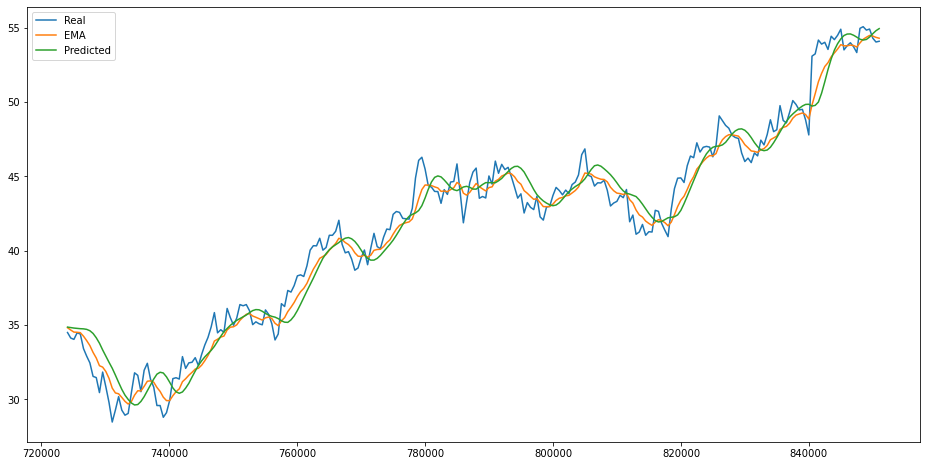

In [25]:
train = symbol[:1500]
valid = symbol[1500:]

valid['Predictions'] = closing_price

plt.figure(figsize=(16,8))

plt.plot(close['close'][1500:])
plt.plot(valid[['EMA','Predictions']])

plt.legend(['Real', 'EMA', 'Predicted'])

In [26]:
s = symbol[len(symbol) - 60:].values
s = s.reshape(-1,1)
s = scaler.transform(s)

In [27]:
s = np.reshape(s, (s.shape[1],s.shape[0],1))

closing_price = model.predict(s)

closing_price = scaler.inverse_transform(closing_price)

# next day's closing price
closing_price

array([[54.99722]], dtype=float32)